In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [ ]:
#Takes list of path names as input, concats files and outputs two dataframes (echos and sensors)
def load_files(echo_files, sensor_files):
    echos = pd.DataFrame()
    sensors = pd.DataFrame()
    for path in echo_files:
        dfe = pd.read_csv(path)
        echos = pd.concat([echos, dfe])
        
    for path in sensor_files:
        dfs = pd.read_csv(path)
        sensors = pd.concat([sensors, dfs])
        
    return echos, sensors


In [ ]:
echo, sensor = load_files(['leg2_echo_prepped.csv', 'leg3_echo_prepped.csv','leg4_echo_prepped.csv'],
           ['leg2_prepped.csv', 'leg3_prepped.csv','leg4_prepped.csv'])

In [93]:
def combine_files(df_echo, df_sensors):
    # datetime type is converted as object when saved to csv, convert back to datetime after reading
    df_echo.dataid = pd.to_datetime(df_echo.dataid, format='%Y-%m-%d %H:%M:%S')
    df_sensors.dataid = pd.to_datetime(df_sensors.dataid, format='%Y-%m-%d %H:%M:%S')
    
    # fix outliers due to freshwater rinsing of the ferrybox system every night
    # avg salinity in atlantic is 33-37 ppm, median in dataset is 35.179. Replace all values below 30 (outliers) with median
    salinity_median = df_sensors['FerryBox.SBE45_Salinity'].median()
    df_sensors['FerryBox.SBE45_Salinity'] = np.where(df_sensors['FerryBox.SBE45_Salinity']<=30 , salinity_median, df_sensors['FerryBox.SBE45_Salinity'])

    conduc_median = df_sensors['FerryBox.SBE45_Conductivity'].median()
    df_sensors['FerryBox.SBE45_Conductivity'] = np.where(df_sensors['FerryBox.SBE45_Conductivity']<=3 , conduc_median, df_sensors['FerryBox.SBE45_Conductivity'])
    
    # replace NaNs with median 
    df_sensors = df_sensors.fillna(df_sensors.median())
    
    # group in intervals of 30 min
    df_sensors = df_sensors.groupby(pd.Grouper(key="dataid", freq="30T")).median()
    df_sensors = df_sensors.reset_index()

    # join sensor and echo dataframes
    final_df = df_echo.merge(df_sensors, on='dataid', how='outer')
    
   
    # Split datetime to date and time separately
    # Date to integer YYYYMMDD
    final_df['date'] = final_df['dataid'].dt.date
    final_df['date']=final_df['date'].apply(lambda x: int(x.strftime("%Y%m%d")))

    # Time to float, e.g 07:30 == 7.5 and 21:00 == 21
    final_df['time'] = final_df['dataid'].dt.time
    final_df['time']=final_df['time'].apply(lambda x: x.hour + x.minute/60)
    final_df['time']=final_df['time'].astype('float')

    # Maybe drop original dataid? For now to numeric
    final_df.dataid = pd.to_numeric(final_df.dataid)
    
    # Remove any row with atleast one NaN value
    final_df = final_df.dropna()

    return final_df


In [94]:
final_df = combine_files(echo, sensor)

<ipython-input-93-03d4ea357894>:15: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df_sensors = df_sensors.fillna(df_sensors.median())


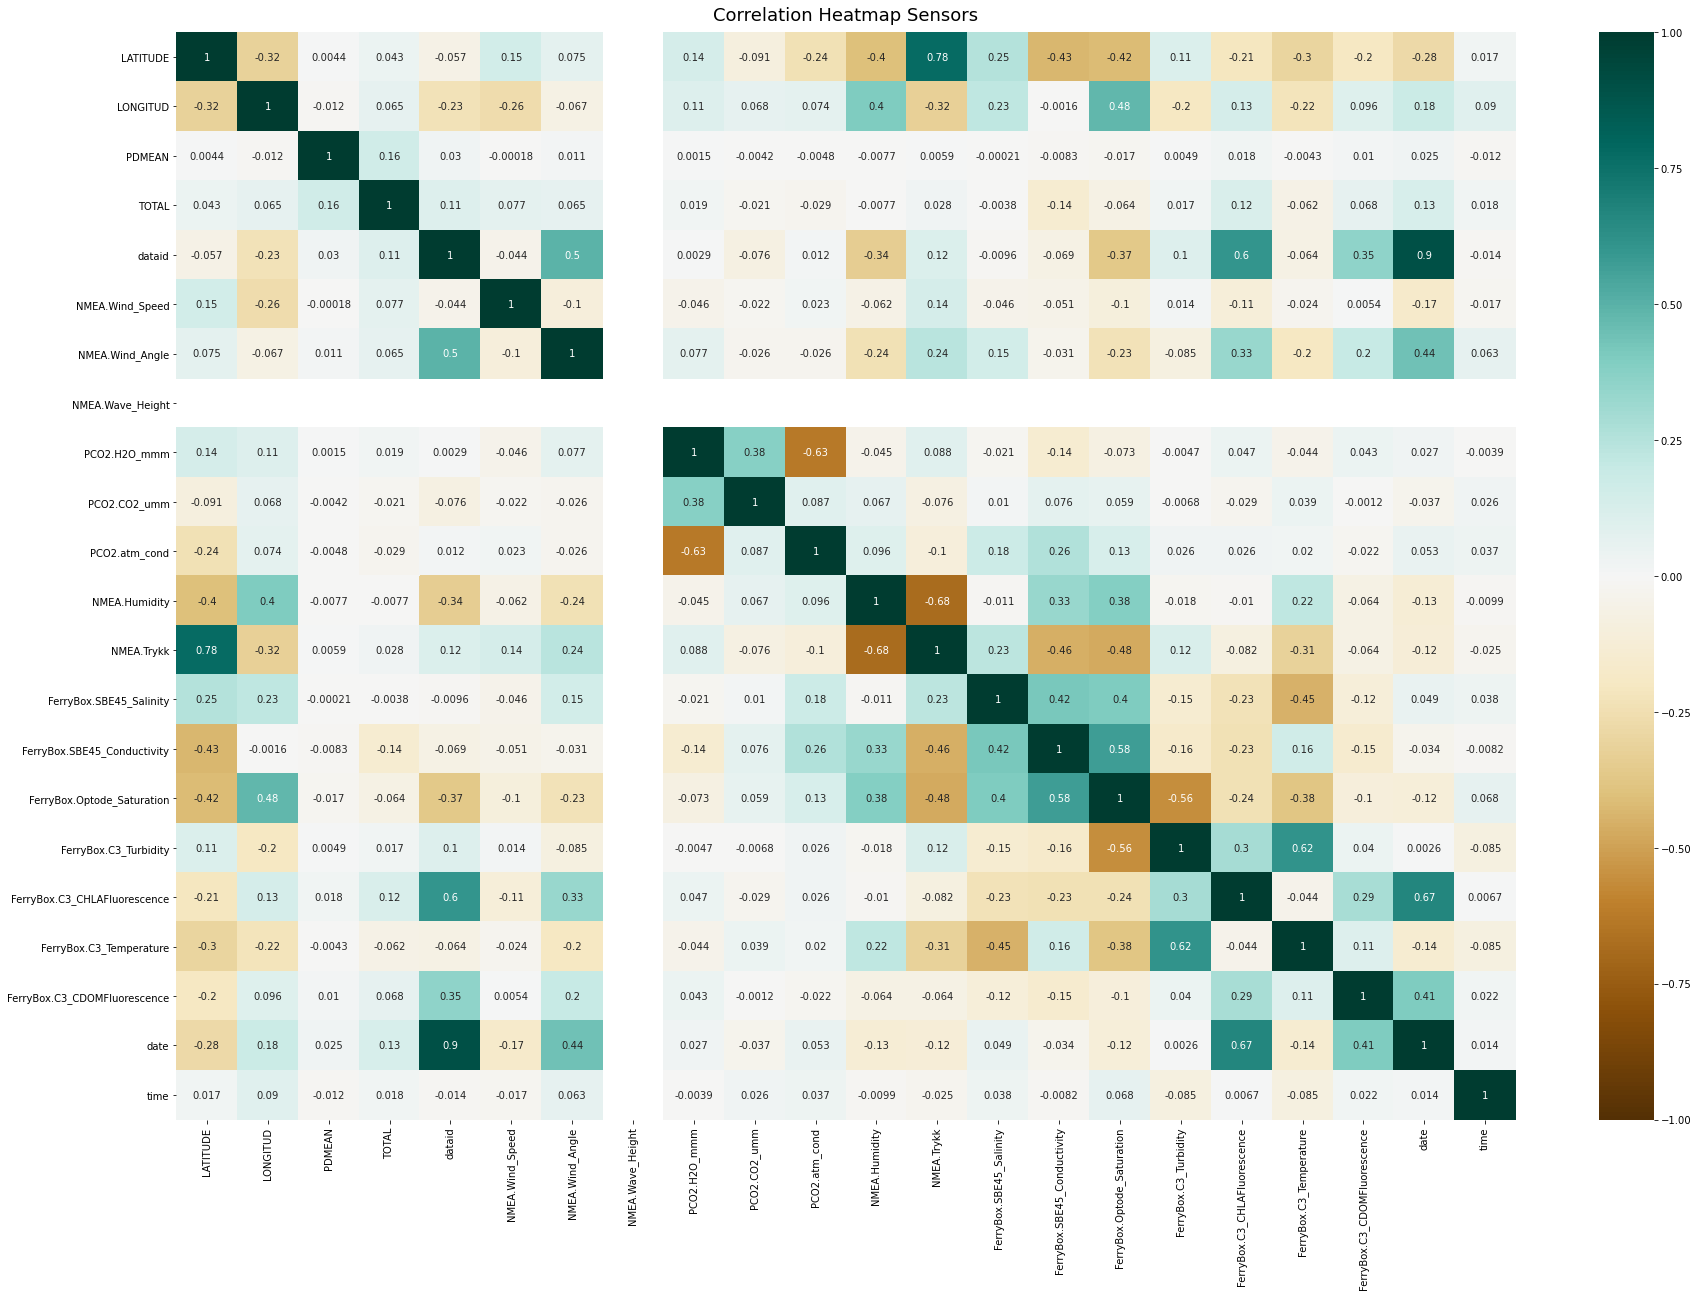

In [95]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = final_df.corr()
plt.figure(figsize=(30, 20))
heatmap = sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap Sensors', fontdict={'fontsize':18}, pad=12);
plt.show()

figure = heatmap.get_figure()   
figure.savefig('corr.jpg', dpi=300, bbox_inches='tight')

In [91]:
final_df

,LATITUDE,LONGITUD,PDMEAN,TOTAL,dataid,NMEA.Wind_Speed,NMEA.Wind_Angle,NMEA.Wave_Height,PCO2.H2O_mmm,PCO2.CO2_umm,...,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence,date,time
0,27.20153,-16.88955,7.5,0.0000,1633428000000000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211005,10.0
1,27.20153,-16.88955,15.0,4.6863,1633428000000000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211005,10.0
2,27.20153,-16.88955,25.0,24.4440,1633428000000000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211005,10.0
3,27.20153,-16.88955,35.0,30.9997,1633428000000000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211005,10.0
4,27.20153,-16.88955,45.0,33.6487,1633428000000000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211005,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289848,NaN,NaN,NaN,NaN,1646033400000000000,9.583333,196.125000,1.88,0.44,417.429993,...,1011.311646,35.643002,5.690,94.639999,-0.37,-0.46,27.700001,-0.14,20220228,7.5
289849,NaN,NaN,NaN,NaN,1646035200000000000,8.714286,186.166672,1.88,0.44,417.429993,...,1011.020020,35.597000,5.684,94.559998,-0.38,-0.46,27.719999,-0.13,20220228,8.0
289850,NaN,NaN,NaN,NaN,1646037000000000000,8.950000,199.333328,1.88,0.44,417.429993,...,1010.293335,35.617001,5.687,94.540001,-0.39,-0.46,27.709999,-0.15,20220228,8.5
289851,NaN,NaN,NaN,NaN,1646038800000000000,11.716666,202.399994,1.88,0.44,417.429993,...,1009.695007,35.504002,5.664,94.500000,-0.37,-0.45,27.660000,-0.14,20220228,9.0


,LATITUDE,LONGITUD,PDMEAN,TOTAL,dataid,NMEA.Wind_Speed,NMEA.Wind_Angle,NMEA.Wave_Height,PCO2.H2O_mmm,PCO2.CO2_umm,...,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence,date,time
341,27.15121,-16.94351,7.5,0.0000,1633431600000000000,10.932143,167.483337,1.88,0.44,417.429993,...,1017.154846,36.477001,5.4545,95.870003,0.545,-0.50,24.469999,-0.15,20211005,11.0
342,27.15121,-16.94351,15.0,6.6924,1633431600000000000,10.932143,167.483337,1.88,0.44,417.429993,...,1017.154846,36.477001,5.4545,95.870003,0.545,-0.50,24.469999,-0.15,20211005,11.0
343,27.15121,-16.94351,25.0,27.0674,1633431600000000000,10.932143,167.483337,1.88,0.44,417.429993,...,1017.154846,36.477001,5.4545,95.870003,0.545,-0.50,24.469999,-0.15,20211005,11.0
344,27.15121,-16.94351,35.0,21.1011,1633431600000000000,10.932143,167.483337,1.88,0.44,417.429993,...,1017.154846,36.477001,5.4545,95.870003,0.545,-0.50,24.469999,-0.15,20211005,11.0
345,27.15121,-16.94351,45.0,22.7452,1633431600000000000,10.932143,167.483337,1.88,0.44,417.429993,...,1017.154846,36.477001,5.4545,95.870003,0.545,-0.50,24.469999,-0.15,20211005,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284567,23.19454,-40.66192,685.0,35.0402,1645304400000000000,3.760000,79.833336,1.88,0.44,417.429993,...,1008.799988,35.882000,5.7960,94.059998,-0.380,-0.45,28.410000,-0.15,20220219,21.0
284568,23.19454,-40.66192,695.0,45.1827,1645304400000000000,3.760000,79.833336,1.88,0.44,417.429993,...,1008.799988,35.882000,5.7960,94.059998,-0.380,-0.45,28.410000,-0.15,20220219,21.0
284569,23.19454,-40.66192,705.0,351.3631,1645304400000000000,3.760000,79.833336,1.88,0.44,417.429993,...,1008.799988,35.882000,5.7960,94.059998,-0.380,-0.45,28.410000,-0.15,20220219,21.0
284570,23.19454,-40.66192,715.0,42.6268,1645304400000000000,3.760000,79.833336,1.88,0.44,417.429993,...,1008.799988,35.882000,5.7960,94.059998,-0.380,-0.45,28.410000,-0.15,20220219,21.0


In [97]:
final_df.to_csv('leg234_data.csv', index = False)

In [ ]:
ferrybox_data_c = pd.DataFrame(ferrybox_data_c)

ferrybox_data_c =gpd.GeoDataFrame(

    ferrybox_data_c, geometry=gpd.points_from_xy(ferrybox_data_c.latitude, ferrybox_data_c.longitude))

ferrybox_data_c.reset_index(level=0, inplace=True)

ferrybox_data_c['timestamp'] = ferrybox_data_c['timestamp'].astype(str)

ferrybox_data_c = ferrybox_data_c.dropna()